this is my first NN notebook, inspired(very much :)
https://www.kaggle.com/naim99/your-first-nlp-competition-submission/notebook#Hashtag-analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#https://www.nltk.org/book/ch02.html

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import string
import collections

plt.style.use('ggplot')
stop=set(nltk.corpus.stopwords.words('english'))

import gensim
import keras

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from multiprocessing import Pool

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv') 
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
print(f'lets look at data shape, there are {train_data.shape[0]} rows and {train_data.shape[1]} columns in train data\n')
print(f' and , there are {test_data.shape[0]} rows and {test_data.shape[1]} columns in test data')

lets look at data shape, there are 7613 rows and 5 columns in train data

 and , there are 3263 rows and 4 columns in test data


In [5]:
print('lets look ak data types present')
train_data.dtypes

lets look ak data types present


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [6]:
print('see whats inside train data')
train_data['text'][100]

see whats inside train data


'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

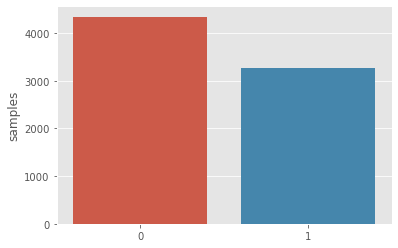

In [7]:
p1 = train_data.target.value_counts()
sns.barplot(p1.index, p1)
plt.gca().set_ylabel('samples')

More tweets are 'non disaster'

let's look at tweets details, like number of chars in a tweeto

Text(0.5, 1.0, 'non-disaster tweets')

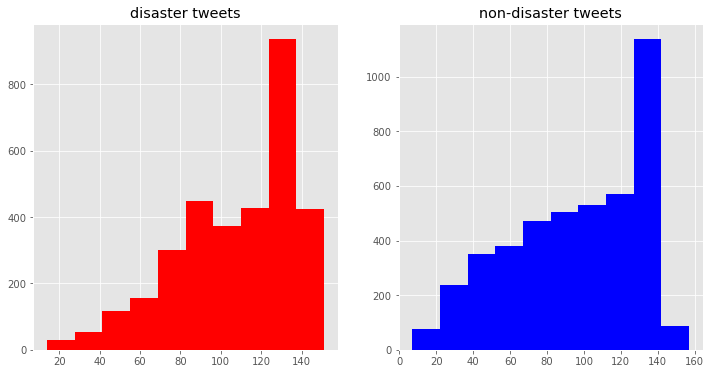

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
tl = train_data[train_data['target'] == 1]['text'].str.len() #tl -> tweet_length

ax1.hist(tl, color='red')
ax1.set_title('disaster tweets')

tl = train_data[train_data['target'] == 0]['text'].str.len() #tl -> tweet_length

ax2.hist(tl, color='blue')
ax2.set_title('non-disaster tweets')

distributions are similiar, thats fine..

now maybey check, the number of words?

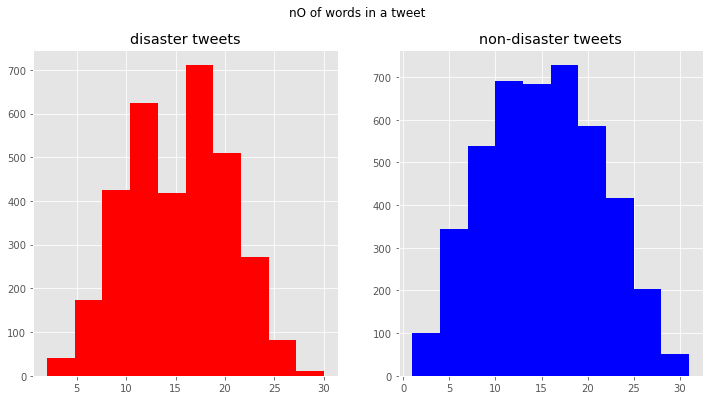

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
#tl -> tweet_length
tl = train_data[train_data['target'] == 1]['text'].str.split().map(lambda x: len(x)) 

ax1.hist(tl, color='red')
ax1.set_title('disaster tweets')

tl = train_data[train_data['target'] == 0]['text'].str.split().map(lambda x: len(x))

ax2.hist(tl, color='blue')
ax2.set_title('non-disaster tweets')
fig.suptitle('nO of words in a tweet')
plt.show()

disaster tweets seems to break free from normal distribution scheme

let's see the avg wordl len in a tweet

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


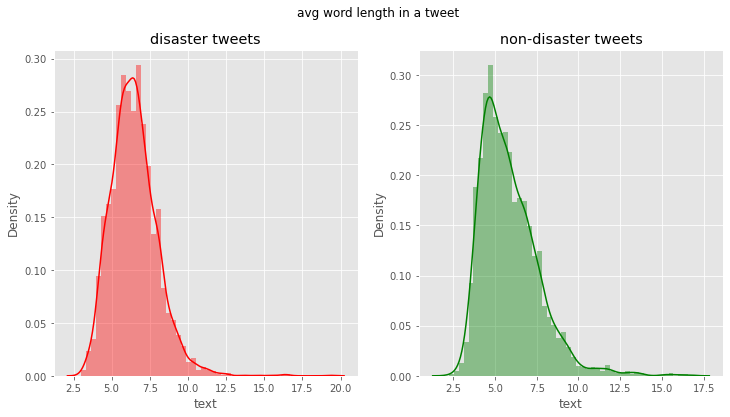

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
#tl -> tweet_length
words = train_data[train_data['target'] == 1]['text'].str.split().apply(lambda x
                                                                : [len(i) for i in x]) 

sns.distplot(words.map(lambda x: np.mean(x)), ax=ax1, color='red' )
ax1.set_title('disaster tweets')

words = train_data[train_data['target'] == 0]['text'].str.split().apply(lambda x
                                                                : [len(i) for i in x])

sns.distplot(words.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('non-disaster tweets')
fig.suptitle('avg word length in a tweet')
plt.show()

There doesn't seem to be any special difference in avd word len beetween tweets, d-nd

In [11]:
word_list = [ word for tweet in train_data['text'].str.split() for word in tweet ]
print('list of words in tweets, below')
word_list

list of words in tweets, below


['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'us',
 'all',
 'Forest',
 'fire',
 'near',
 'La',
 'Ronge',
 'Sask.',
 'Canada',
 'All',
 'residents',
 'asked',
 'to',
 "'shelter",
 'in',
 "place'",
 'are',
 'being',
 'notified',
 'by',
 'officers.',
 'No',
 'other',
 'evacuation',
 'or',
 'shelter',
 'in',
 'place',
 'orders',
 'are',
 'expected',
 '13,000',
 'people',
 'receive',
 '#wildfires',
 'evacuation',
 'orders',
 'in',
 'California',
 'Just',
 'got',
 'sent',
 'this',
 'photo',
 'from',
 'Ruby',
 '#Alaska',
 'as',
 'smoke',
 'from',
 '#wildfires',
 'pours',
 'into',
 'a',
 'school',
 '#RockyFire',
 'Update',
 '=>',
 'California',
 'Hwy.',
 '20',
 'closed',
 'in',
 'both',
 'directions',
 'due',
 'to',
 'Lake',
 'County',
 'fire',
 '-',
 '#CAfire',
 '#wildfires',
 '#flood',
 '#disaster',
 'Heavy',
 'rain',
 'causes',
 'flash',
 'flooding',
 'of',
 'streets',
 'in',
 'Manitou,',
 'Colorado',
 'Springs',
 'areas',
 "I'm

<BarContainer object of 40 artists>

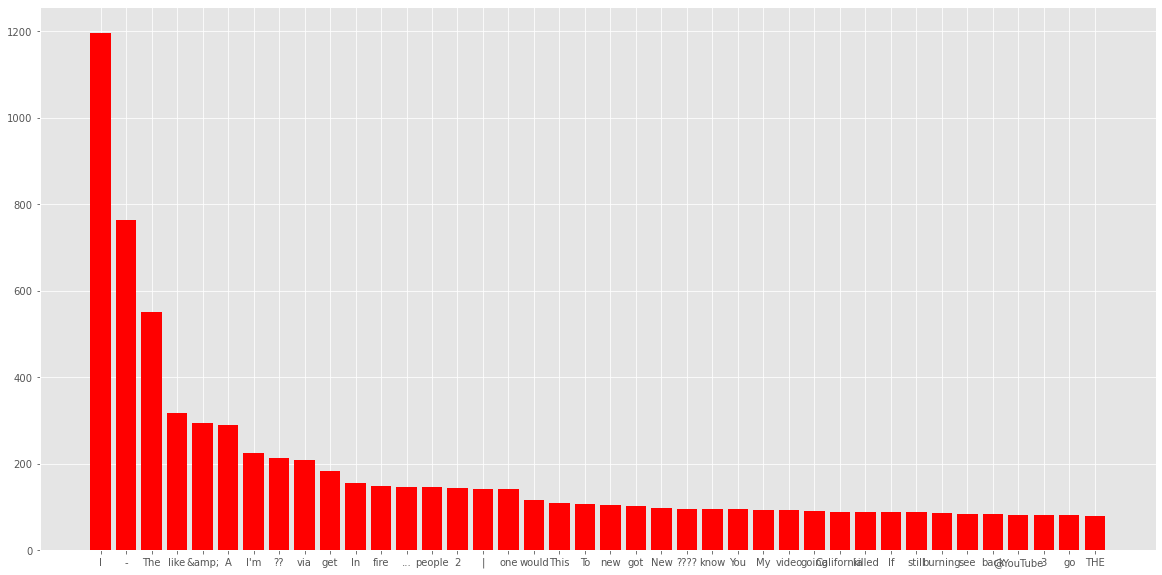

In [12]:
dicto = collections.defaultdict(int)

for word in word_list:
    if word not in stop:
        dicto[word] +=1


top_words = sorted(dicto.items(), key=lambda x: x[1], reverse=True)[:40]

x,y = zip(*top_words)
plt.rcParams['figure.figsize'] = (20,10)
plt.bar(x,y, color='red')

<BarContainer object of 30 artists>

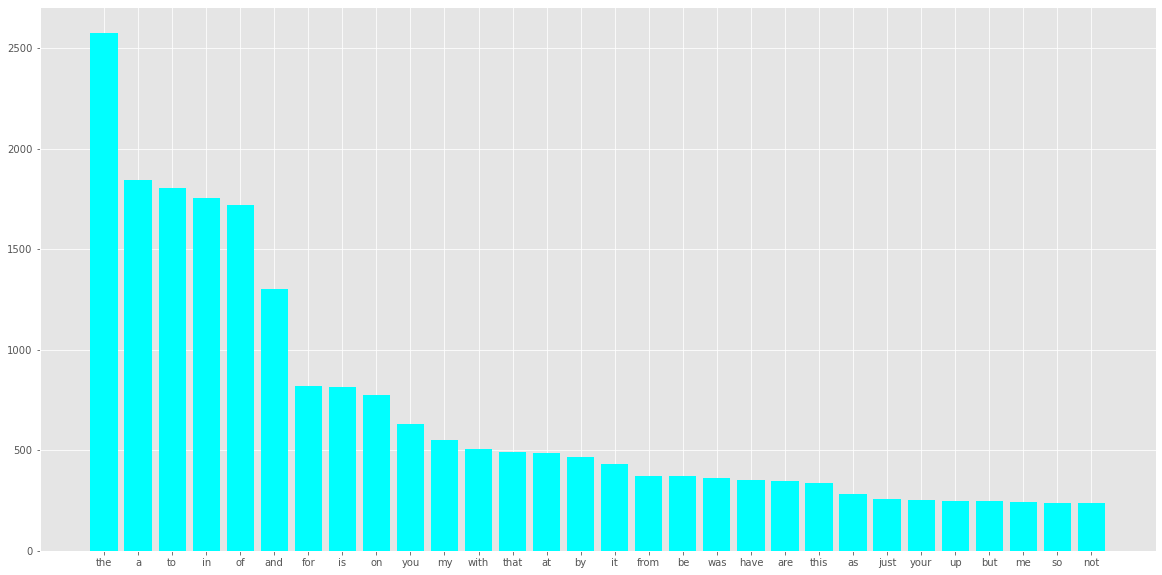

In [13]:
stop = nltk.corpus.stopwords.words('english')
#https://www.nltk.org/book/ch02.html

dicto = collections.defaultdict(int)

for word in word_list:
    if word in stop:
        dicto[word] +=1


top_words = sorted(dicto.items(), key=lambda x: x[1], reverse=True)[:30]

x,y = zip(*top_words)
plt.rcParams['figure.figsize'] = (20,10)
plt.bar(x,y, color='cyan')

and punctuation

<BarContainer object of 23 artists>

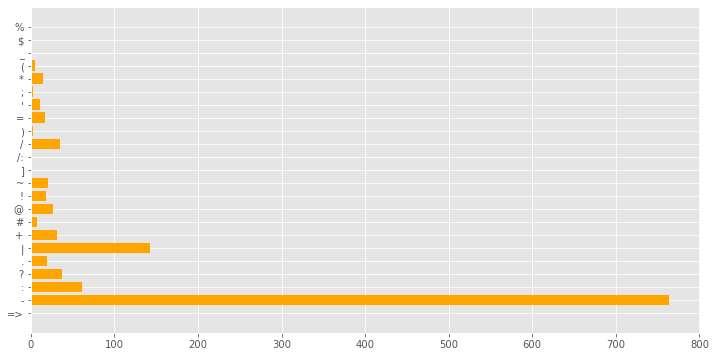

In [14]:
plt.figure(figsize=(12,6))
dicto = collections.defaultdict(int)
special_chars = string.punctuation

for i in word_list:
    if i in special_chars:
        dicto[i] +=1

x,y = zip(*dicto.items())
plt.barh(x,y, color='orange')

let's look at most common words in non-disaster tweets

In [15]:
common_words_to_be = train_data[train_data.target == 0].text.apply(lambda x
                                                    : [word.lower() for word in x.split()])

counter_words = collections.Counter()

for str_ in common_words_to_be:
    counter_words.update(str_)
    
print(counter_words.most_common(51))

[('the', 1877), ('a', 1238), ('to', 1181), ('i', 1052), ('and', 911), ('of', 895), ('in', 805), ('you', 625), ('is', 586), ('my', 541), ('for', 486), ('on', 424), ('with', 374), ('-', 374), ('that', 357), ('it', 341), ('this', 286), ('be', 284), ('like', 250), ('have', 240), ('by', 240), ('so', 235), ('are', 231), ('at', 229), ('just', 229), ('your', 225), ('me', 221), ('was', 216), ('but', 216), ('not', 198), ("i'm", 195), ('&amp;', 190), ('??', 183), ('out', 179), ('up', 178), ('will', 177), ('if', 177), ('from', 177), ('all', 173), ('new', 163), ('get', 161), ('as', 160), ('or', 155), ('we', 148), ('when', 144), ('has', 143), ('he', 143), ('no', 140), ('about', 139), ('they', 133), ('an', 130)]


and most common ones in disaster tweets

In [16]:
common_words_to_be = train_data[train_data.target == 1].text.apply(lambda x
                                                    : [word.lower() for word in x.split()])

counter_words = collections.Counter()

for str_ in common_words_to_be:
    counter_words.update(str_)
    
print(counter_words.most_common(51))

[('the', 1330), ('in', 1144), ('of', 919), ('a', 897), ('to', 753), ('and', 494), ('on', 410), ('for', 394), ('-', 389), ('is', 344), ('at', 303), ('i', 284), ('by', 274), ('from', 243), ('with', 188), ('that', 181), ('after', 181), ('this', 177), ('as', 167), ('are', 166), ('was', 165), ('it', 163), ('fire', 151), ('have', 140), ('my', 130), ('over', 123), ('you', 121), ('more', 121), ('via', 117), ('up', 114), ('an', 113), ('be', 112), ('...', 106), ('&amp;', 105), ('has', 104), ('suicide', 103), ('who', 100), ('no', 99), ('disaster', 97), ('but', 95), ('police', 94), ('people', 93), ('been', 93), ('when', 93), ('killed', 92), ('like', 91), ('not', 90), ('california', 88), ('than', 85), ('just', 84), ('families', 81)]


let's see at word distributions,  1(blue) is disaster

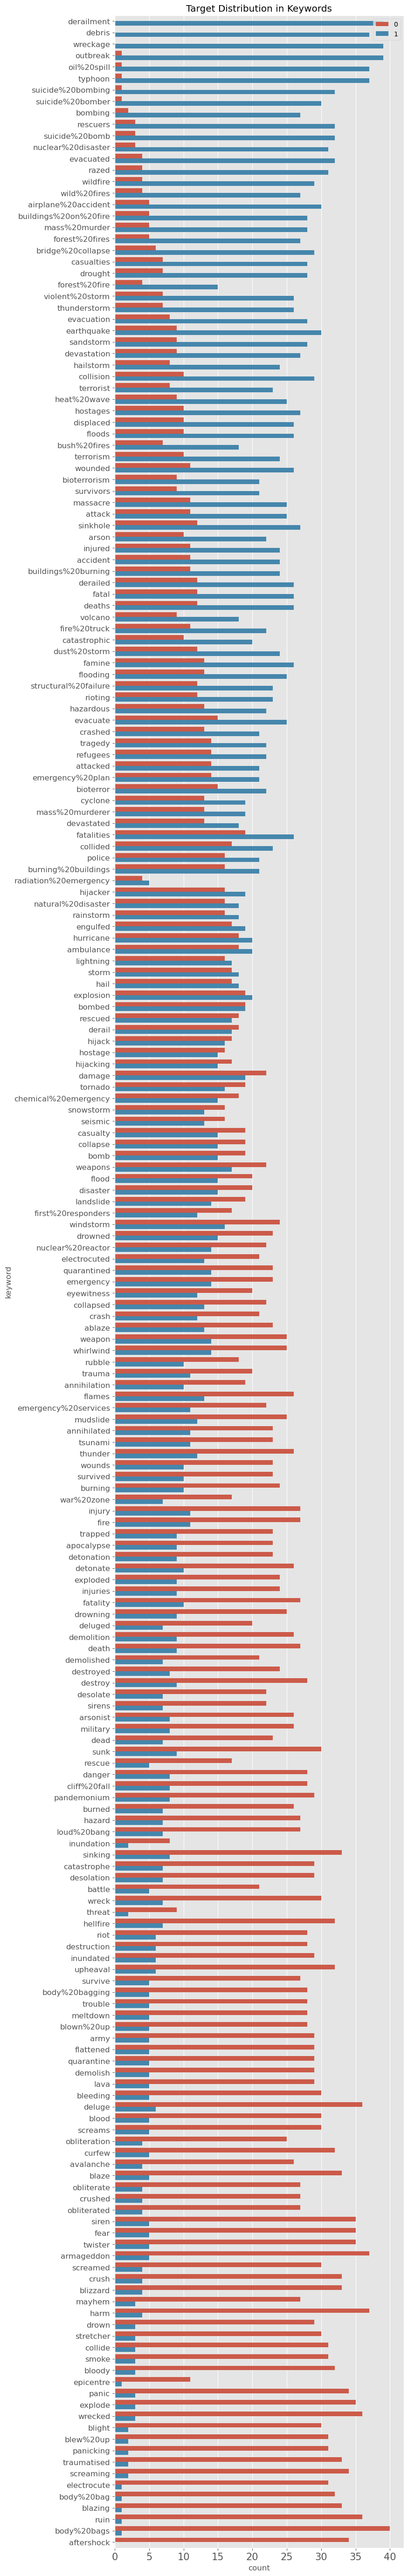

In [17]:
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_data.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_data.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_data.drop(columns=['target_mean'], inplace=True)

**Let's do a dataset without, special characters like flags, emots, other...**

In [18]:
def clean_tweets(df, col, new_col):
    df[new_col] = df[col].str.lower()
    
    #remove numbers
    df[new_col] = df[new_col].apply(lambda x: re.sub(r"\d+","" , x))
    #remove url's
    df[new_col] = df[new_col].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "", x))
    #remove HTML tags
    df[new_col] = df[new_col].apply(lambda x: re.sub(r"<.*?>", "", x))
    #remove emojis
    df[new_col] = df[new_col].apply(lambda x: re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", x))
    return df

In [19]:
data_clean = clean_tweets(train_data, 'text', 'text_clean')
data_clean_test = clean_tweets(test_data, 'text' ,'text_clean')
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


for speed, let's remove stopwords

In [20]:
stop = nltk.corpus.stopwords.words('english')

data_clean['text_clean'] = data_clean['text_clean'].apply(lambda x: " ".join(
            [word for word in x.split() if word not in (stop)]))
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


now, tokenization

In [21]:
data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x
                                                        : nltk.word_tokenize(x))
data_clean.head()

,id,keyword,location,text,target,text_clean,text_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us,"[deeds, reason, #, earthquake, may, allah, for..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...,"[residents, asked, 'shelter, place, ', notifie..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ...","[,, people, receive, #, wildfires, evacuation,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...,"[got, sent, photo, ruby, #, alaska, smoke, #, ..."


lemmatize

In [22]:
from nltk.stem import WordNetLemmatizer

def word_lemmatizer(text):
    return [WordNetLemmatizer().lemmatize(i) for i in text]

data_clean['text_clean_tokens'] = data_clean['text_tokens'].apply(lambda x
                                                                  :word_lemmatizer(x))

data_clean = data_clean.drop(['keyword','location','text'],axis=1)
data_clean.head()


,id,target,text_clean,text_tokens,text_clean_tokens
0,1,1,deeds reason #earthquake may allah forgive us,"[deeds, reason, #, earthquake, may, allah, for...","[deed, reason, #, earthquake, may, allah, forg..."
1,4,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, ., canada]"
2,5,1,residents asked 'shelter place' notified offic...,"[residents, asked, 'shelter, place, ', notifie...","[resident, asked, 'shelter, place, ', notified..."
3,6,1,", people receive #wildfires evacuation orders ...","[,, people, receive, #, wildfires, evacuation,...","[,, people, receive, #, wildfire, evacuation, ..."
4,7,1,got sent photo ruby #alaska smoke #wildfires p...,"[got, sent, photo, ruby, #, alaska, smoke, #, ...","[got, sent, photo, ruby, #, alaska, smoke, #, ..."


In [23]:
X_train = data_clean['text_clean'].sample(frac=0.7, random_state=133)
y_train = data_clean['target'].loc[data_clean['target'].index.isin(X_train.index)]
X_val   = data_clean['text_clean'].loc[~data_clean['text_clean'].index.isin(
                                                    X_train.index)]
y_val   = data_clean['target'].loc[data_clean['target'].index.isin(X_val.index)]

In [24]:
print('X_train shape => ',X_train.shape, '\n')
print('y_train shape => ',y_train.shape, '\n')
print('X_val shape => ',X_val.shape, '\n')
print('y_val shape => ',y_val.shape, '\n')

assert data_clean['target'].shape[0] == y_train.shape[0] + y_val.shape[0]

X_train shape =>  (5329,) 

y_train shape =>  (5329,) 

X_val shape =>  (2284,) 

y_val shape =>  (2284,) 



In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_clean['text_clean'], 
                                                 data_clean['target'], test_size=0.3)

In [26]:
X_train

6063    #sandiego #news sinkhole disrupts downtown tro...
2384                      derail train at... smithsonian?
1232    fire hazard associated installation non-compli...
6595    news-uk islamist cleric anjem choudary charged...
2184    aircraft debris found island mh malaysia confirms
                              ...                        
3036    #sismo ml . near coast western turkey: magnitu...
6873    @uchicago faculty members pushing university o...
6254    #lakeeffect #snowstorm twill denim jackets ***...
2327                        year old ring fort demolished
1868                       yhngsjlg tweeted secret crush:
Name: text_clean, Length: 5329, dtype: object

let's encode tweets

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding = 'utf-8',
                       ngram_range=(1,1),
                       max_features=5000,
                       norm='l2',
                       sublinear_tf=True,
                       smooth_idf=True)

train_features = tfidf.fit_transform(X_train).toarray()

In [28]:
print(train_features[1])
print(train_features.shape)

[0. 0. 0. ... 0. 0. 0.]
(5329, 5000)


In [29]:
pd.DataFrame(train_features, 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(X_train))],
             columns=tfidf.get_feature_names())

,__,_minimehh,aa,aba,abandon,abandoned,abbott,abbswinston,abc,abcnews,...,ûïa,ûïhatchet,ûïrichmond,ûïstretcher,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûó
sentence 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 5325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
val_features = tfidf.transform(X_val).toarray()
print(val_features.shape)

(2284, 5000)


In [31]:
train_labels = y_train
val_labels   = y_val

now, let's get net ready!

In [32]:
X_train

6063    #sandiego #news sinkhole disrupts downtown tro...
2384                      derail train at... smithsonian?
1232    fire hazard associated installation non-compli...
6595    news-uk islamist cleric anjem choudary charged...
2184    aircraft debris found island mh malaysia confirms
                              ...                        
3036    #sismo ml . near coast western turkey: magnitu...
6873    @uchicago faculty members pushing university o...
6254    #lakeeffect #snowstorm twill denim jackets ***...
2327                        year old ring fort demolished
1868                       yhngsjlg tweeted secret crush:
Name: text_clean, Length: 5329, dtype: object

In [33]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Activation, SpatialDropout1D, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import tensorflow_hub as hub

In [34]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [35]:
import tokenization

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [36]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [37]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 26.7 s, sys: 5.06 s, total: 31.8 s
Wall time: 34.9 s


In [38]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [39]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [40]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [41]:
model = build_model(bert_layer, max_len=160)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [42]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/3
381/381 [==============================] - 414s 989ms/step - loss: 0.4599 - accuracy: 0.7946 - val_loss: 0.3749 - val_accuracy: 0.8444
Epoch 2/3
381/381 [==============================] - 373s 979ms/step - loss: 0.2589 - accuracy: 0.9037 - val_loss: 0.3922 - val_accuracy: 0.8477
Epoch 3/3
381/381 [==============================] - 373s 979ms/step - loss: 0.1268 - accuracy: 0.9527 - val_loss: 0.5205 - val_accuracy: 0.8234


In [43]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [44]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

In [45]:

'''
num_words = len(np.amax(X_train))
model = Sequential()


embedding = Embedding(num_words+1, 32, trainable=False, mask_zero=True)


model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr = 3e-4)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()
'''

"\nnum_words = len(np.amax(X_train))\nmodel = Sequential()\n\n\nembedding = Embedding(num_words+1, 32, trainable=False, mask_zero=True)\n\n\nmodel.add(embedding)\nmodel.add(SpatialDropout1D(0.2))\nmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))\nmodel.add(Dense(1, activation='sigmoid'))\n\noptimizer = Adam(lr = 3e-4)\n\nmodel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])\n\nmodel.summary()\n"

In [46]:
'''history = model.fit(train_features, train_labels, batch_size=4, epochs=10, 
                    validation_data=(val_features, val_labels), verbose=1)'''

'history = model.fit(train_features, train_labels, batch_size=4, epochs=10, \n                    validation_data=(val_features, val_labels), verbose=1)'